# Recommender Systems on MovieLens
Authors: Kevin Lagos & Andrés Navarro

In [ ]:
#Librerías 
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import operator
import random
import matplotlib.pyplot as plt

## Datasets

   ### 1. MovieLens: 
   Es uno de los datasets más populares de recomendación y recopila las preferencias de usuarios de internet con respecto a películas que son evaluadas de 0 a 5 estrellas. Este dataset ha sido utilizado en diversos estudios de investigación en áreas como la recomendación personalizada y la psicología social.  
* <b>Archivos: </b>
    - ML_ratings.csv: contiene los ratings dados por usuarios a películas. Se compone por las columnas user_id, movie_id y rating. 
    - movies.csv: contiene la metadata sobre las películas. Incluye las columnas movie_id, title y genres (donde se encuentran los géneros de la película separados por "|"). 
 
* <b>Cantidad de ratings</b>: 100836
* <b>Cantidad de usuarios</b>: 610
* <b>Cantidad de películas</b>: 9724
* <b>Calificación</b> 0 a 5 (valores enteros) 

Referencias: [Movielens Dataset](https://grouplens.org/datasets/movielens/) 
   

#### Preprocesamiento de datos

In [ ]:
#Carga de datos
movies = pd.read_csv("ML_ratings.csv")
moviesIds = pd.read_csv("movies.csv")

### 2. Book-Crossing: 
Es un datasets de ratings de libros recolectado por Cai-Nicolas Ziegler desde la <i>Book-Crossing community</i>. El dataset original contiene 1,149,780 ratings generados por 278,858 usuarios a 271,379 libros. 

* <b>Archivos</b>: 
    - BX_ratings.csv: contiene los ratings dados por usuarios a diferentes libros. Se compone de las columnas user_id, ISBN (identificador para los libros) y rating.
    - books.csv: contiene los títulos de libros asociados a los códigos ISBN (utilizados como item_id). Se compone de las columnas ISBN y title. 

* <b>Cantidad de ratings</b>: 359263
* <b>Cantidad de usuarios</b>: 10775
* <b>Cantidad de libros</b>: 10773
* <b>Calificación</b>: 0 a 10 (valores enteros)

Referencias: [Book-Crossing Dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/)

#### Preprocesamiento de datos

In [ ]:
# Carga de datos
books = pd.read_csv("BX_ratings.csv")
booksIds = pd.read_csv("books.csv")

### 3. Jester: 
Es un dataset desarrollado por Ken Goldberg y su equipo en la Universidad de Berkeley, el cual contiene alrededor de 6 millones de ratings con respecto a 150 chistes cortos. 
* <b>Archivos</b>:
    - JT_ratings.csv: contiene los ratings dados por usuarios a diferentes chistes cortos. Se compone por las columnas joke_id, user_id y rating. 
    - jokes.csv: contiene 

* <b>Cantidad de ratings</b>: 199900
* <b>Cantidad de usuarios</b>: 1999
* <b>Cantidad de chistes</b>: 100 
* <b>Calificación</b>: -10 a 10 (valores reales)
    
Referencias: [Jester Dataset](http://eigentaste.berkeley.edu/dataset/)

In [ ]:
df = pd.read_csv("JT_ratings.csv")
df.head()

,joke_id,user_id,rating
0,0,1,5.10
1,1,1,4.90
2,2,1,1.75
3,3,1,-4.17
4,4,1,5.15


## Instrucciones

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11227-020-03266-2/MediaObjects/11227_2020_3266_Fig1_HTML.png" title="Title text" width="60%" />
<center> <i> Figura 1. Collaborative Filtering. </i> </center>

## 1. User based Collaborative Filtering

In [ ]:
#Obtencion de la similaridad de coseno de un usuario con el resto
def getCosSim(matrix, user):
  user1 = matrix[matrix.index == user].to_numpy()[0]
  dicSims = dict()
  otherUsers = matrix[matrix.index != user]

  for index, row in otherUsers.iterrows():
    user2 = matrix[matrix.index == index].to_numpy()[0]
    user1NotNan = np.array([])
    user2NotNan = np.array([])
    for i in range(len(user1)):
      if not np.isnan(user1[i]) and not np.isnan(user2[i]):
        user1NotNan = np.append(user1NotNan, user1[i])
        user2NotNan = np.append(user2NotNan, user2[i])
    #Solo si la intersección entre estos no es vacia se calcula el coseno
    if user1NotNan.size > 0:
      norma = np.linalg.norm(user1NotNan) * np.linalg.norm(user2NotNan)
      #Evitar que el denominador de la similaridad sea cero
      if norma > 0:
        cosineSim = np.sum(user1NotNan*user2NotNan) / norma
        dicSims[index] = cosineSim
  return dicSims

#Obtencion de los ratings para peliculas/libros no vistas/os por un usuario dado
def estimateRating(matrix, ratingMean, otherUsers, user):
  mean = float(ratingMean[ratingMean["user_id"] == user]["rating_mean"])
  user1 = matrix[matrix.index == user]
  moviesToCheck = list(user1.columns[np.isnan(user1.iloc[0])])
  diccRatings = {}
  #Obtener todas las peliculas que el usuario no ha dado rating
  for movieId in moviesToCheck:
    numerador = 0
    denominador = 0
    #Se recorren los vecinos más cercanos a este usuario
    for userId, similitud in otherUsers:
      value = matrix.loc[userId, movieId]
      if not np.isnan(value):
        numerador += value * similitud
        denominador += similitud
    if denominador != 0:  
      diccRatings[movieId] = mean + numerador/denominador
  return diccRatings

# Porcentaje de sparsity de la matriz
def getSparsity(dataF):
  dimx = dataF.shape[0]
  dimy = dataF.shape[1]
  missingValsCount = sum(dataF.isnull().sum(axis=0))
  return (missingValsCount/(dimx * dimy))

### Movies Dataset

Debido a que tenemos un mayor conocimiento de películas de super-héroes se decidió clasificar 10 películas de esta índole, para ver si, efectivamente, se logran dar recomendaciones de películas similares. Sin embargo, se trata de no tener ninguna inclinación específica respecto a algún género presente en el dataset (a pesar de que seguramente se repetirán algunos), o por ejemplo, películas producidas sólo por Marvel o sólo de animación. También se intentó incluir películas antiguas.

| movie_id | título | géneros | calificación |
|----------|--------|---------|--------------|
| 122912   | Avengers: Infinity War - Part I (2018)        |    Action\|Adventure\|Sci-Fi      |       5.0       |
|  2640    | Superman (1978)  |  Action\|Adventure\|Sci-Fi       | 4.0              |
|     27311      |    Batman Beyond: Return of the Joker (2000)     |   Action\|Animation\|Crime\|Sci-Fi\|Thriller      |  4.5            |
|     153     |   Batman Forever (1995)     |    Action\|Adventure\|Comedy\|Crime    |   2.0           |
|  122926        |  Untitled Spider-Man Reboot (2017)      |  Action\|Adventure\|Fantasy       |   4.0           |
| 106072         |   Thor: The Dark World (2013)     |   Action\|Adventure\|Fantasy\|IMAX      |       3.0       |
|       3213   |    Batman: Mask of the Phantasm     |   Animation\|Children      |       3.5       |
|     87430     |    Green Lantern (2011)    |    Action\|Adventure\|Sci-Fi     |     1.0         |
|    58559      |     Dark Knight, The (2008)    |     Action\|Crime\|Drama\|IMAX    |    5.0          |
| 143355 |Wonder Woman (2017) |Action\|Adventure\|Fantasy | 4.5|






In [ ]:
random.seed(2021)
np.random.seed(2021)
#Usuario creado
userId = 777
userMovies = [122912, 2640, 27311, 153, 122926, 106072, 3213,87430,58559,143355]
userRatings = [5.0,4.0,4.5,2.0,4.0,3.0,3.5,1.0,5.0,4.5]
#Nueva matriz para añadir al nuevo usuario
moviesNewUser = movies

for i in range(10):
  dfTemp = pd.DataFrame([[userId, userMovies[i], userRatings[i]]], columns = ["user_id", "movie_id", "rating"], index=[i] )
  moviesNewUser = moviesNewUser.append(dfTemp, ignore_index=True)


In [ ]:
#Matrices pivot a usar
user_item_matrix_og = movies.pivot(index = 'user_id', columns ='movie_id', values = 'rating')
user_item_matrix_new = moviesNewUser.pivot(index = 'user_id', columns ='movie_id', values = 'rating')

print("Porcentaje de sparsity para la matriz sin el usuario nuevo: " + str(getSparsity(user_item_matrix_og)))
print("Porcentaje de sparsity para la matriz con el usuario nuevo: " + str(getSparsity(user_item_matrix_new)))



Porcentaje de sparsity para la matriz sin el usuario nuevo: 0.9830003169443864
Porcentaje de sparsity para la matriz con el usuario nuevo: 0.9830264565510546


In [ ]:
#Rating promedio
rating_mean= moviesNewUser.groupby(['user_id'], as_index = False, sort = False).mean().rename(columns = {'rating': 'rating_mean'})[['user_id','rating_mean']]
#Mean centered rating
adjusted_ratings = pd.merge(moviesNewUser,rating_mean,on = 'user_id', how = 'left', sort = False)
adjusted_ratings['rating_adjusted']=adjusted_ratings['rating']-adjusted_ratings['rating_mean']
#Pivoteo para dejar la matriz usuarios-items con los mean centered ratings
adjusted_ratings = adjusted_ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating_adjusted')
adjusted_ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,NaN,-0.366379,NaN,NaN,-0.366379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.935897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.555556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.555556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.363636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.363636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.363636,0.363636,NaN,-0.636364,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


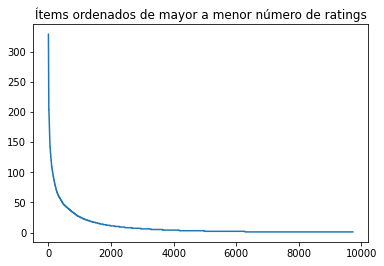

In [ ]:
frecRating = user_item_matrix_new.count(axis=0)
frecRating = frecRating.tolist()


frecRating.sort()
frecRating.reverse()
plt.plot([x for x in range(0, len(frecRating))] ,frecRating)
plt.title("Ítems ordenados de mayor a menor número de ratings")
plt.show()

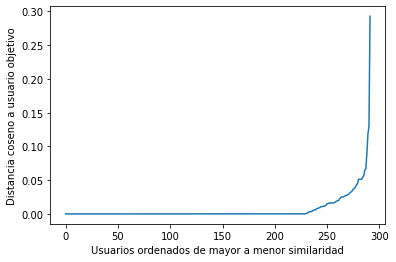

Cantidad de usuarios con similitud mayor a 0.99:  244


In [ ]:
#Calculo de similitudes para el nuevo usuario
cosenoDic = getCosSim(user_item_matrix_new, 777)
cosenoDicSorted = sorted(cosenoDic.items(), key=operator.itemgetter(1), reverse=True)

#Grafico para visualizar la distancia coseno a este
plt.plot([ (1- x[1]) for x in cosenoDicSorted])
plt.xlabel("Usuarios ordenados de mayor a menor similaridad")
plt.ylabel("Distancia coseno a usuario objetivo")
plt.show()

print("Cantidad de usuarios con similitud mayor a 0.99: ", len([ (1- x[1]) for x in cosenoDicSorted if x[1] > 0.99]))

In [ ]:
#En base a 5 usuarios con similitud 1
ratingsEstimadosK5 = estimateRating(adjusted_ratings, rating_mean, cosenoDicSorted[:5], 777)
#En base a 24 usuarios con similitud 1
ratingsEstimadosK24 = estimateRating(adjusted_ratings, rating_mean, cosenoDicSorted[:24], 777)
#En base a 50 usuarios con similitud 1
ratingsEstimadosK50 = estimateRating(adjusted_ratings, rating_mean, cosenoDicSorted[:50], 777)
#En base a 100 usuarios con similitud 1
ratingsEstimadosK100 = estimateRating(adjusted_ratings, rating_mean, cosenoDicSorted[:100], 777)
#En base a 244 usuarios con similitud 1
ratingsEstimadosK244 = estimateRating(adjusted_ratings, rating_mean, cosenoDicSorted[:244], 777)
#En base a 260 usuarios con similitud mayor a 0.95, para no calcular los rating a partir de
#similitude coseno igual a uno solamente
ratingsEstimadosK260 = estimateRating(adjusted_ratings, rating_mean, cosenoDicSorted[:260], 777)

ratingsTotales = [ratingsEstimadosK5, ratingsEstimadosK24, ratingsEstimadosK50, ratingsEstimadosK100, ratingsEstimadosK244, ratingsEstimadosK260]
for i in range(len(ratingsTotales)):
  ratingsTotales[i] = sorted(ratingsTotales[i].items(), key=operator.itemgetter(1), reverse=True)[:5]

In [ ]:
kPrueba = [5, 24, 50, 100, 244, 260]

for rating in range(len(ratingsTotales)):
  print("------------ \n K = ", kPrueba[rating])
  print("Vecinos más cercanos: \n")
  print(cosenoDicSorted[:kPrueba[rating]])
  for movieId, sim in ratingsTotales[rating]:
    print(moviesIds[moviesIds["movie_id"] == movieId].to_string())

------------ 
 K =  5
Vecinos más cercanos: 

[(1, 1.0), (2, 1.0), (5, 1.0), (6, 1.0), (7, 1.0)]
      movie_id           title        genres
1187      1584  Contact (1997)  Drama|Sci-Fi
      movie_id                                        title                  genres
1494      2019  Seven Samurai (Shichinin no samurai) (1954)  Action|Adventure|Drama
      movie_id                                           title  genres
2892      3869  Naked Gun 2 1/2: The Smell of Fear, The (1991)  Comedy
      movie_id                                                 title                       genres
3984      5618  Spirited Away (Sen to Chihiro no kamikakushi) (2001)  Adventure|Animation|Fantasy
   movie_id                               title  genres
4         5  Father of the Bride Part II (1995)  Comedy
------------ 
 K =  24
Vecinos más cercanos: 

[(1, 1.0), (2, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (10, 1.0), (11, 1.0), (14, 1.0), (15, 1.0), (16, 1.0), (17, 1.0), (22, 1.0), (24, 1.0),

### Books Dataset

Para el usuario que ha leído 10 libros, se decidió caracterizarlo como un lector de fantasía y magia, seleccionando libros de Harry Potter y el Señor de los Anillos. Se eligieron los libros con su nombre en inglés y, en el caso de que estuviese duplicado (como algunos de Harry Potter), se eligió el primero que aparecía en la lista.

| ISBN | título |  calificación |
|----------|--------|---------|
| 0590353403| Harry Potter and the Sorcerer's Stone (Book 1)| 8.0|
| 0439064872|Harry Potter and the Chamber of Secrets (Book 2) | 6.0|
|0439136350 | Harry Potter and the Prisoner of Azkaban (Book 3)| 9.0|
| 0439139597|Harry Potter and the Goblet of Fire (Book 4) | 10.0|
| 043935806X| Harry Potter and the Order of the Phoenix (Book 5)| 8.0|
|0064409430 |"The Magician's Nephew (The Chronicles of Narnia, Book 1, Full-Color Collector's Edition)" | 8.0|
|0345339703 |"The Fellowship of the Ring (The Lord of the Rings, Part 1)" | 7.0|
|0345339711 | "The Two Towers (The Lord of the Rings, Part 2)"| 8.0|
|0345339738 | "The Return of the King (The Lord of the Rings, Part 3)"| 9.0|
|0345324366 |The Complete Guide to Middle-Earth: From the Hobbit to the Silmarillion | 5.0|

In [ ]:
# Usuario creado
random.seed(2021)
np.random.seed(2021)

userId = 359263
userBooks = ["0590353403", "0439064872", "0439136350", "0439139597", "043935806X", "0064409430", "0345339703", "0345339711", "0345339738", "0345324366"]
userRatings = [8.0, 6.0, 9.0, 10.0, 8.0, 8.0, 7.0, 8.0, 9.0, 5.0]
booksNewUser = books

for i in range(10):
  dfTemp = pd.DataFrame([[userId, userBooks[i], userRatings[i]]], columns = ["user_id", "ISBN", "rating"], index=[i] )
  booksNewUser = booksNewUser.append(dfTemp, ignore_index=True)

In [ ]:
#Matrices pivot a usar
user_item_matrix_og = books.pivot(index = 'user_id', columns ='ISBN', values = 'rating')
user_item_matrix_new = booksNewUser.pivot(index = 'user_id', columns ='ISBN', values = 'rating')

print("Porcentaje de sparsity para la matriz sin el usuario nuevo: " + str(getSparsity(user_item_matrix_og)))
print("Porcentaje de sparsity para la matriz con el usuario nuevo: " + str(getSparsity(user_item_matrix_new)))

Porcentaje de sparsity para la matriz sin el usuario nuevo: 0.9969050149650142
Porcentaje de sparsity para la matriz con el usuario nuevo: 0.9969057904736314


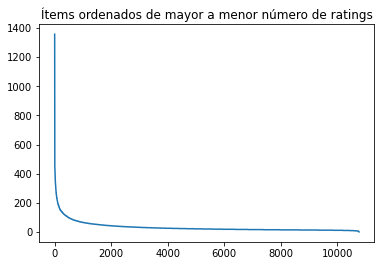

In [ ]:
frecRating = user_item_matrix_new.count(axis=0)
frecRating = frecRating.tolist()

frecRating.sort()
frecRating.reverse()
plt.title("Ítems ordenados de mayor a menor número de ratings")
plt.plot([x for x in range(0, len(frecRating))] ,frecRating)
plt.show()

In [ ]:
#Rating promedio
rating_mean_books = booksNewUser.groupby(['user_id'], as_index = False, sort = False).mean().rename(columns = {'rating': 'rating_mean'})[['user_id','rating_mean']]
#Mean centered ratings
adjusted_ratings = pd.merge(booksNewUser,rating_mean_books,on = 'user_id', how = 'left', sort = False)
adjusted_ratings['rating_adjusted']=adjusted_ratings['rating']-adjusted_ratings['rating_mean']
#Pivoteo para dejar la matriz usuarios-items con los mean centered ratings
adjusted_ratings = adjusted_ratings.pivot(index = 'user_id', columns ='ISBN', values = 'rating_adjusted')

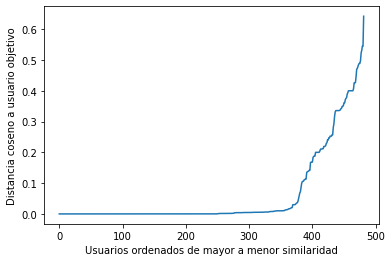

Cantidad de usuarios con similitud mayor a 0.99:  343


In [ ]:
#Calculo de similitudes para el nuevo usuario
cosenoDic = getCosSim(user_item_matrix_new, 359263)
cosenoDicSorted = sorted(cosenoDic.items(), key=operator.itemgetter(1), reverse=True)

#Grafico para visualizar la distancia coseno a este
plt.plot([ (1- x[1]) for x in cosenoDicSorted])
plt.xlabel("Usuarios ordenados de mayor a menor similaridad")
plt.ylabel("Distancia coseno a usuario objetivo")
plt.show()

print("Cantidad de usuarios con similitud mayor a 0.99: ", len([ (1- x[1]) for x in cosenoDicSorted if x[1] > 0.99]))

In [ ]:
#En base a 5 usuarios con similitud 1
ratingsEstimadosK5 = estimateRating(adjusted_ratings, rating_mean_books, cosenoDicSorted[:5], 359263)
#En base a 20 usuarios con similitud 1
ratingsEstimadosK20 = estimateRating(adjusted_ratings, rating_mean_books, cosenoDicSorted[:20], 359263)
#En base a 50 usuarios con similitud 1
ratingsEstimadosK50 = estimateRating(adjusted_ratings, rating_mean_books, cosenoDicSorted[:50], 359263)
#En base a 103 usuarios con similitud 1
ratingsEstimadosK103 = estimateRating(adjusted_ratings, rating_mean_books, cosenoDicSorted[:103], 359263)
#En base a 343 usuarios con similitud 1
ratingsEstimadosK343 = estimateRating(adjusted_ratings, rating_mean_books, cosenoDicSorted[:343], 359263)
#En base a 380usuarios con similitud mayor a 0.95, para no calcular los rating a partir de
#similitude coseno igual a uno solamente
ratingsEstimadosK380 = estimateRating(adjusted_ratings, rating_mean_books, cosenoDicSorted[:380], 359263)

ratingsTotales = [ratingsEstimadosK5, ratingsEstimadosK20, ratingsEstimadosK50, ratingsEstimadosK103, ratingsEstimadosK343, ratingsEstimadosK380]
for i in range(len(ratingsTotales)):
  ratingsTotales[i] = sorted(ratingsTotales[i].items(), key=operator.itemgetter(1), reverse=True)[:5]

In [ ]:
kPrueba = [5, 20, 50, 103, 343, 380]

for rating in range(len(ratingsTotales)):
  print("------------ \n K = ", kPrueba[rating])
  print("Vecinos más cercanos: \n")
  print(cosenoDicSorted[:kPrueba[rating]])
  for ISBN, sim in ratingsTotales[rating]:
    print(booksIds[booksIds["ISBN"] == ISBN].to_string())


------------ 
 K =  5
Vecinos más cercanos: 

[(638, 1.0), (2179, 1.0), (4600, 1.0), (4802, 1.0), (7346, 1.0)]
             ISBN                                                                                                                                                                   title
20315  0020868308  Mere Christianity: A revised and enlarged edition, with a new introduction, of the three books, The case for Christianity, Christian behaviour, and Beyond personality
             ISBN                                          title
10935  0140178406  Aunt Dimity's Death (Aunt Dimity (Paperback))
            ISBN                                                     title
7878  0140430725  Pride and Prejudice (The Penguin English Library, El 72)
             ISBN                                                                title
20368  0312966199  All Things Bright and Beautiful (All Things Bright &amp; Beautiful)
          ISBN              title
52  0440225701  The Street La

### Experimentos adicionales

Se decidió realizar experimentos adicionales para probar otra forma de pre-procesar la matriz de usuarios-ítems, rellenando esta con ceros (y estandarizándola), para que así, al momento de calcular la similaridad, no sea calculada entre una cantidad reducida de valores para los ítems y se tome en consideración el vector completo, intentando mitigar, de esta manera, el problema de obtener demasiados valores igual a uno para la similaridad.

In [ ]:
#Funcion para recuperar las similaridades con esta nueva implementacion
def getCosSimDicc(matrix, simMatrix, user):
  diccSims = {}
  posInSimMatrix = 0
  userPos = 0
  for index, row in matrix.iterrows():
    if index == user:
      userPos = posInSimMatrix
    posInSimMatrix +=1
  posInSimMatrix = 0
  for index, row in matrix.iterrows():
    if(index != user):
      diccSims[index] =  simMatrix[userPos][posInSimMatrix]
    posInSimMatrix +=1
  return diccSims

#### Movies Dataset


In [ ]:
#Matriz pivot a usar
user_item_matrix_new = moviesNewUser.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
#Matriz estandarizada a [0, 1]
for index, row in user_item_matrix_new.iterrows():
  row= (row-row.min())/(row.max()-row.min())
  user_item_matrix_new.loc[index] = row

#Rating promedio
rating_mean= moviesNewUser.groupby(['user_id'], as_index = False, sort = False).mean().rename(columns = {'rating': 'rating_mean'})[['user_id','rating_mean']]
#Mean centered rating
adjusted_ratings = pd.merge(moviesNewUser,rating_mean,on = 'user_id', how = 'left', sort = False)
adjusted_ratings['rating_adjusted']=adjusted_ratings['rating']-adjusted_ratings['rating_mean']
#Pivoteo para dejar la matriz usuarios-items con los mean centered ratings
adjusted_ratings = adjusted_ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating_adjusted')

In [ ]:
#Dado que no se encuentran valores NaN, se puede calcular de forma más rápida la similaridad de coseno entre usuarios
moviesSimMatrix = cosine_similarity(user_item_matrix_new)

#En caso de obtener valores nan, debido a, por ejemplo, división por cero, se reemplaza la similaridad por cero
moviesSimMatrix[np.isnan(moviesSimMatrix)] = 0

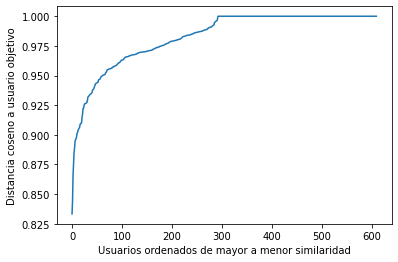

Cantidad de usuarios con similitud mayor a 0.10:  10


In [ ]:
cosenoDic = getCosSimDicc(user_item_matrix_new, moviesSimMatrix, 777)
cosenoDicSorted = sorted(cosenoDic.items(), key=operator.itemgetter(1), reverse=True)

#Grafico para visualizar la distancia coseno a este
plt.plot([ (1- x[1]) for x in cosenoDicSorted])
plt.xlabel("Usuarios ordenados de mayor a menor similaridad")
plt.ylabel("Distancia coseno a usuario objetivo")
plt.show()

print("Cantidad de usuarios con similitud mayor a 0.10: ", len([ (1- x[1]) for x in cosenoDicSorted if x[1] > 0.10]))

In [ ]:
#En base a 5 usuarios 
ratingsEstimadosK5 = estimateRating(adjusted_ratings, rating_mean, cosenoDicSorted[:5], 777)
#En base a 24 usuarios 
ratingsEstimadosK24 = estimateRating(adjusted_ratings, rating_mean, cosenoDicSorted[:24], 777)
#En base a 50 usuarios 
ratingsEstimadosK50 = estimateRating(adjusted_ratings, rating_mean, cosenoDicSorted[:50], 777)
#En base a 100 usuarios 
ratingsEstimadosK100 = estimateRating(adjusted_ratings, rating_mean, cosenoDicSorted[:100], 777)
#En base a 244 usuarios 
ratingsEstimadosK244 = estimateRating(adjusted_ratings, rating_mean, cosenoDicSorted[:244], 777)
#En base a 260 usuarios
ratingsEstimadosK260 = estimateRating(adjusted_ratings, rating_mean, cosenoDicSorted[:260], 777)

ratingsTotales = [ratingsEstimadosK5, ratingsEstimadosK24, ratingsEstimadosK50, ratingsEstimadosK100, ratingsEstimadosK244, ratingsEstimadosK260]
for i in range(len(ratingsTotales)):
  ratingsTotales[i] = sorted(ratingsTotales[i].items(), key=operator.itemgetter(1), reverse=True)[:5]

In [ ]:
kPrueba = [5, 24, 50, 100, 244, 260]

for rating in range(len(ratingsTotales)):
  print("------------ \n K = ", kPrueba[rating])
  print("Vecinos más cercanos: \n")
  print(cosenoDicSorted[:kPrueba[rating]])
  for movieId, sim in ratingsTotales[rating]:
    print(moviesIds[moviesIds["movie_id"] == movieId].to_string())

------------ 
 K =  5
Vecinos más cercanos: 

[(25, 0.1667413696392527), (184, 0.15572140922183647), (596, 0.13426286672422408), (291, 0.12532116655178688), (60, 0.11531026764185304)]
      movie_id              title                         genres
1701      2288  Thing, The (1982)  Action|Horror|Sci-Fi|Thriller
      movie_id                                     title                                    genres
2260      3000  Princess Mononoke (Mononoke-hime) (1997)  Action|Adventure|Animation|Drama|Fantasy
      movie_id                title                         genres
3562      4878  Donnie Darko (2001)  Drama|Mystery|Sci-Fi|Thriller
      movie_id                                         title                            genres
4151      5971  My Neighbor Totoro (Tonari no Totoro) (1988)  Animation|Children|Drama|Fantasy
      movie_id                                               title                               genres
5791     31658  Howl's Moving Castle (Hauru no ugoku shiro) 

#### Books Dataset

In [ ]:
#Matriz pivot a usar
user_item_matrix_new = booksNewUser.pivot(index = 'user_id', columns ='ISBN', values = 'rating').fillna(0)
#Matriz estandarizada a [0, 1]
for index, row in user_item_matrix_new.iterrows():
  row= (row-row.min())/(row.max()-row.min())
  user_item_matrix_new.loc[index] = row
#En algunos casos luego de estandarizar existen valores NaN
user_item_matrix_new = user_item_matrix_new.fillna(0)

#Rating promedio
rating_mean_books = booksNewUser.groupby(['user_id'], as_index = False, sort = False).mean().rename(columns = {'rating': 'rating_mean'})[['user_id','rating_mean']]
#Mean centered ratings
adjusted_ratings = pd.merge(booksNewUser,rating_mean_books,on = 'user_id', how = 'left', sort = False)
adjusted_ratings['rating_adjusted']=adjusted_ratings['rating']-adjusted_ratings['rating_mean']
#Pivoteo para dejar la matriz usuarios-items con los mean centered ratings
adjusted_ratings = adjusted_ratings.pivot(index = 'user_id', columns ='ISBN', values = 'rating_adjusted')

In [ ]:
#Dado que no se encuentran valores NaN, se puede calcular de forma más rápida la similaridad de coseno entre usuarios
booksSimMatrix = cosine_similarity(user_item_matrix_new)
 
#En caso de obtener valores nan, debido a, por ejemplo, división por cero, se reemplaza la similaridad por cero
booksSimMatrix[np.isnan(booksSimMatrix)] = 0

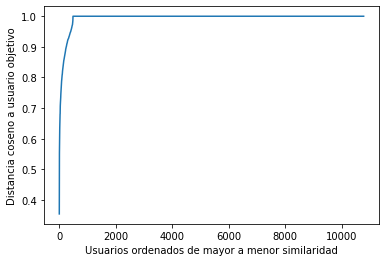

Cantidad de usuarios con similitud mayor a 0.35:  20


In [ ]:
cosenoDic = getCosSimDicc(user_item_matrix_new,booksSimMatrix, 359263)
cosenoDicSorted = sorted(cosenoDic.items(), key=operator.itemgetter(1), reverse=True)

#Grafico para visualizar la distancia coseno a este
plt.plot([ (1- x[1]) for x in cosenoDicSorted])
plt.xlabel("Usuarios ordenados de mayor a menor similaridad")
plt.ylabel("Distancia coseno a usuario objetivo")
plt.show()


print("Cantidad de usuarios con similitud mayor a 0.35: ", len([ (1- x[1]) for x in cosenoDicSorted if x[1] > 0.35]))

In [ ]:
#En base a 5 usuarios 
ratingsEstimadosK5 = estimateRating(adjusted_ratings, rating_mean_books, cosenoDicSorted[:5], 359263)
#En base a 20 usuarios
ratingsEstimadosK20 = estimateRating(adjusted_ratings, rating_mean_books, cosenoDicSorted[:20], 359263)
#En base a 50 usuarios 
ratingsEstimadosK50 = estimateRating(adjusted_ratings, rating_mean_books, cosenoDicSorted[:50], 359263)
#En base a 103 usuarios 
ratingsEstimadosK103 = estimateRating(adjusted_ratings, rating_mean_books, cosenoDicSorted[:103], 359263)
#En base a 244 usuarios 
ratingsEstimadosK244 = estimateRating(adjusted_ratings, rating_mean_books, cosenoDicSorted[:244], 359263)
#En base a 260 usuarios
ratingsEstimadosK260 = estimateRating(adjusted_ratings, rating_mean_books, cosenoDicSorted[:260], 359263)

ratingsTotales = [ratingsEstimadosK5, ratingsEstimadosK20, ratingsEstimadosK50, ratingsEstimadosK103, ratingsEstimadosK244, ratingsEstimadosK260]
for i in range(len(ratingsTotales)):
  ratingsTotales[i] = sorted(ratingsTotales[i].items(), key=operator.itemgetter(1), reverse=True)[:5]

In [ ]:
kPrueba = [5, 20, 50, 103, 343, 380]

for rating in range(len(ratingsTotales)):
  print("------------ \n K = ", kPrueba[rating])
  print("Vecinos más cercanos: \n")
  print(cosenoDicSorted[:kPrueba[rating]])
  for ISBN, sim in ratingsTotales[rating]:
    print(booksIds[booksIds["ISBN"] == ISBN].to_string())

------------ 
 K =  5
Vecinos más cercanos: 

[(231081, 0.6455288501107681), (161872, 0.488091287030554), (6431, 0.4813180812410763), (79475, 0.4629238275861726), (160434, 0.45889995856888266)]
             ISBN                                                                        title
23342  0060924799  More Tales of the City (Maupin, Armistead. Tales of the City Series, V. 2.)
             ISBN                                  title
13873  0345336275  Foundation (Foundation Series ; Bk 1)
            ISBN               title
7686  0743436210  Hearts in Atlantis
             ISBN                         title
33804  0312863551  The Moon Is a Harsh Mistress
            ISBN                                                    title
7188  0060193395  Body for Life: 12 Weeks to Mental and Physical Strength
------------ 
 K =  20
Vecinos más cercanos: 

[(231081, 0.6455288501107681), (161872, 0.488091287030554), (6431, 0.4813180812410763), (79475, 0.4629238275861726), (160434, 0.458899958

### Conclusiones



a.   Para el dataset de películas se obtuvieron las siguientes recomendaciones :
      
* Midnight Cowboy (1969)
* Dune (1984)
* Dune (2000)
* Once (2006)
* Shadow of the Vampire (2000)

Por otro lado, para el dataset de libros se obtuvieron las siguientes recomendaciones:
* The Pilgrimage
* My Uncle Oswald
* Brave New World
* One Flew over the Cuckoo's Nest
* The Autobiography of Malcolm X

Respecto a las recomendaciones de peliculas, no se obtuvo el resultado esperado, ya que ninguna película de super-héroes aparece en la recomendación. Luego de investigar un poco, las recomendaciones que más sentido podrían tener serían las de Dune, que están relacionadas por el género de ciencia ficción. Tal vez se debió calificar películas con un caracter un poco más acotado y enfocarse sólo en películas de Batman actuales por ejemplo, ya que muchas de las películas recomendadas son muy antiguas. Para las recomendaciones de libros, sólo *The Pilgrimage* guarda cierta relación con la temática de los libros seleccionados. Sin embargo, estos resultados pueden no ser del todo malos, ya que un buen sistema de recomendación buscaría diversificar los ítems que le ofrece a sus usuarios, ofreciendo cosas que no le podrían llamar la atención en primera instancia. 

Considerando la experimentación adicional, para el dataset de películas se obtuvo:

* Thing, The (1982)  
* Princess Mononoke (Mononoke-hime)
* Donnie Darko (2001)  
* My Neighbor Totoro (Tonari no Totoro) (1988)  
* Howl's Moving Castle (Hauru no ugoku shiro)

Por otro lado, para el dataset de libros se encontraron las siguientes recomendaciones:

* The 9 Steps to Financial Freedom
* Don't Sweat the Small Stuff and It's All Small Stuff : Simple Ways to Keep the Little Things from Taking Over Your Life (Don't Sweat the Small Stuff Series)
* Chicken Soup for the Soul (Chicken Soup for the Soul)
* Chicken Soup for the Kid's Soul : 101 Stories of Courage, Hope and Laughter (Chicken Soup for the Soul (Paperback Health Communications))
* The Canterbury Tales (Bantam Classics)

En este caso se puede observar una tendencia respecto a películas del estudio Ghibli, mientras que para los libros no se puede evidenciar ningún patrón. A pesar de haber procesado de manera distinta la matriz de usuarios-ítems, usada para obtener las similaridades entre estos, se tienen resultados que no son muy buenos.

b.   Se escogieron 24 vecinos cercanos para la recomendación de películas y los 103 vecinos más cercanos para la recomendación de libros, básandonos en la regla de que un buen valor para knn corresponde a $\sqrt(n)$, siendo $n$ la cantidad de usuarios. Lamentablemente, al ser una matriz demasiado *sparse* y un usuario demasiado nuevo, ocurrió en múltiples ocasiones que el valor para la similaridad del coseno corresponde a un valor igual a 1, debido a que podría ocurrir que la intersección entre las películas que vieron los usuarios serían pocas (por ejemplo 1) y se diese la coincidencia de que las calificasen con el mismo valor, dando como resultado dicho valor para la similaridad, siendo poco informativo para el uso que le queremos dar. Lo anterior está relacionado con el problema del *cold start*, ya que el usuario al tener una baja interacción con los ítems es difícil que genere una buena inferencia y pueda comparar efectivamente la similitud respecto a otros usuarios. Sería bueno tratar de agregar data temporal a este usuario para poder realizar una mejor recomendación, en base a, por ejemplo, los ítems más vistos, o en base a los usuarios que han visto todos los ítems que este vió, intentando esquivar el problema de la similaridad igual a uno. Otra alternativa, pero que complejizaría el problema, sería el hecho de agregar nuevas características del usuario, para ayudar a la inferencia, como geolocalización, lengua prefente, etc. para ayudar a mitigar el problema de *cold start*. 

A medida que se aumenta el parámetro para **k**, naturalmente varíaban los ratings para los ítems y las recomendaciones finales, pero al tener el problema de que una gran cantidad de usuarios tenía el valor de la similaridad de coseno igual a uno, no es del todo correcto confiar en las recomendaciones dadas para los **k** que son menores al número de usuarios con este valor. Lo anterior viene dado  a que uno podría elegir otro conjunto de los 10 primeros usuarios, ignorando el orden dado por la ejecución de python, que también tendrían la similaridad de coseno igual a uno y obtener un resultado completamente distinto. Para los dos últimos valores de **k** en cada dataset se encontró cierta repetición de las recomendaciones, lo que puede estar dado por el hecho de que, al tener tantos usuarios a considerar, se comiencen a recomendar los ítems más polulares y mejor calificados, ignorando lo que ha visto el usuario objetivo. Cabe destacar que para *k = 20* y *k = 50* con el dataset de libros, se recomendó un libro de Harry Potter.

En la experimentación adicional las distancias coseno a los vecinos más cercanos cambiaron radicalmente, siendo mayor a 80 en el caso de las películas y teniendo sólo 10 usuarios con similaridad mayor a 0.1 respecto al usuario objetivo. Mientras que para el dataset de películas, si bien se presenta una reducción en los valores de las similaridades, se presentan valores mayores, siendo 20 la cantidad de usuarios con similaridad mayor a 0.35. Por esta reducción en los valores de la similaridad se decidió escoger valores más pequeños para **k** en ambos casos, ya que ahora esta sería una medida más informativa. Para el dataset de películas se escogió  *K = 5* y para el de libros *K = 20*, intentando mantener valores "altos" (en comparación a todos los demás) para la similaridad. Para el primer dataset, al escoger valores mayores nuevamente ocurre cierta repetición entre las recomendaciones, sin embargo, para el dataset de libros esto no es así, lo que puede estar dado porque la proporción de usuarios tomados es menor, teniendo que considerar más usuarios aún para evidenciar dicho efecto. 

c. El porcentaje de *sparsity* para la matriz usuarios-ítems para el caso del dataset de películas es de 98.300% si no contamos al usuario nuevo y 98.302% en el caso de contarlo. Para el dataset de libros es 99.690% en ambos casos, debido a que la cantidad de usuarios y libros es considerablemente mayor a las que el dataset de películas posee, por lo que la adición del nuevo usuario no se refleja en el porcentaje a pesar de dar 3 decimales de precisión. Las desventajas de UBCF al tener una matriz con una gran cantidad de *missing values* corresponden a que, por un lado, la función de similaridad entre usuarios usada se ve afectada negativamente por el porcentaje de *sparsity* de la matriz (lo que, sin embargo, puede ser mitigado al seleccionar un valor de k grande), además, es injusto el considerar a dos usuarios similares cuando uno ha visto un número reducido de ítems y el otro ha visto una gran cantidad, por lo que ha ocurrido una intersección entre estos y se ha calculado la similaridad en base a lo que ha visto el usuario con poca data. Además, si esta intersección coincide en los ratings dados, provocaría que la similaridad de coseno sea igual a uno lo que no tiene mucho sentido, ya que el primer usuario sólo ha puntuado una porción de lo que el otro ha puntuado.

En la experimentación adicional, el porcentaje de *sparsity* de la matriz también juega en contra, ya que las similaridades de coseno son bastante bajas si lo que uno desea es recuperar usuarios que sean similares entre sí, descartándo prácticamente a la totalidad de los usuarios en el caso de que se busque considerar usuarios con una similaridad mayor a 0.5. En este caso, la similaridad de coseno se ve afectada por la gran cantidad de ceros al momento de obtener los vectores, ya que la intersección entre estos será muy pequeña y como en esta métrica se divide el producto punto entre ambos vectores por la multiplicación de la norma de ambos, estas normas podrían llegar a ser demasiado grandes en comparación al producto punto.

Como comentario adicional, se pudo pensar en construir otro usuario en base a los ítems que han sido mas calificados por los usuarios, ya que tal vez, para estos datasets en específico, los ítems que hemos elegido no han sido lo suficientemente calificados y al utilizar ítems más vistos tendríamos más información de ratings. También, se pensó en evitar incluir usuarios que coinciden con menos de un número determinado de ítems vistos con el usuario objetivo, intentando así, calcular similaridades con más ítems como input.

## 2. Item based Collaborative Filtering (40 puntos) 

La segunda parte de la tarea constará de las siguientes secciones: 
1. Implementación de un sistema de recomendación de filtro colaborativo basado en ítems utilizando los k ítems más cercanos. Para esta parte, se debe utilizar <b> similaridad coseno </b> como medida de similaridad entre los ítems. Además, el parámetro k debe ser escogido por ustedes. 

2. Se ingresa nuevo usuario al sistema, se le pide que califique 10 productos (a elección) y a partir de eso se le realiza la recomendación de 5 productos que no ha calificado. Para poder llevar a cabo la recomendación recordar los siguientes pasos:
    >a. Se debe generar la matriz de similaridad entre productos basada en la similaridad coseno.
    
    >b. Para realizar la recomendación, se debe predecir el rating de todos los productos que el usuario nuevo del sistema no haya calificado aún. Para esto, se deben obtener los k ítems más cercanos al ítem a predecir y se debe predecir su rating en base a la <i> weighted sum </i> de los ratings de dichos k ítems. 
    
    >c. Una vez predecidos los ratings para todos los productos sin calificación, se deben recomendar al usuario los 5 productos con mayor rating predecido. 

3. Concluir y responder las siguientes preguntas: 

   >a. ¿Cuáles fueron las 5 recomendaciones obtenidas? Analice y concluya respecto a estos resultados.  
    
   >b. ¿Qué cantidad de vecinos cercanos (k) se escogió para la recomendación? ¿En qué influye la elección de este parámetro? ¿Qué sucede a medida que aumento este parámetro?
    
   >c. ¿Cuáles son las ventajas de este enfoque respecto al anterior? 


<i>Importante: Esto debe ser realizado para ambos datasets escogidos</i>

In [ ]:
#Obtención de similaridad coseno para un item con los demás
def getCosSimItems(matrix, item, otherItems):
  item1 = matrix[matrix.index == item].to_numpy()[0]
  dicSims = dict()
  
  for index, row in otherItems.iterrows():
    item2 = matrix[matrix.index == index].to_numpy()[0]
    item1NotNan = np.array([])
    item2NotNan = np.array([])
    for i in range(len(item1)):
      if not np.isnan(item1[i]) and not np.isnan(item2[i]):
        item1NotNan = np.append(item1NotNan, item1[i])
        item2NotNan = np.append(item2NotNan, item2[i])
    #Solo si la intersección entre estos no es vacia se calcula el coseno
    if item1NotNan.size > 0:
      norma = np.linalg.norm(item1NotNan) * np.linalg.norm(item2NotNan)
      #Evitar que el denominador de la similaridad sea cero
      if norma > 0:
        cosineSim = np.sum(item1NotNan*item2NotNan) / norma
        dicSims[index] = cosineSim
  return dicSims


#Obtencion de los ratings para peliculas/libros no vistas/os por un usuario dado
def estimateRatingItems(matrix, matrixAdjusted, moviesToCheck, user, otherItems, kneighs):
  listDicRating = []
  for i in kneighs:
    listDicRating.append({})
  for movieId in moviesToCheck:
    #Dicionario con los valores de similaridad que son utiles para posteriormente
    #calcular el rating
    cosenoDic = getCosSimItems(matrixAdjusted, movieId, otherItems)
    cosenoDic = sorted(cosenoDic.items(), key=operator.itemgetter(1), reverse=True)
    for i in range(len(kneighs)):
      neighbor = kneighs[i]
      cosenoDicNeighbor = cosenoDic[:neighbor]
      numerador = 0
      denominador = 0
      for itemId, similitud in cosenoDicNeighbor:
        value = matrix.loc[itemId, user]
        if not np.isnan(value):
          numerador += similitud * value
          denominador += abs(similitud)
      if denominador != 0:
        ratingEstimado = numerador/denominador  
        listDicRating[i][movieId] = ratingEstimado
  return listDicRating

### Movies Dataset

In [ ]:
user_item_matrix_og = movies.pivot(index = 'user_id', columns ='movie_id', values = 'rating')
user_item_matrix_new = moviesNewUser.pivot(index = 'user_id', columns ='movie_id', values = 'rating')
#Matrices pivot a usar, se cambia la orientación
#Ahora las filas corresponden a las películas
item_user_matrix_og = movies.pivot(index = 'movie_id', columns ='user_id', values = 'rating')
item_user_matrix_new = moviesNewUser.pivot(index = 'movie_id', columns ='user_id', values = 'rating')

In [ ]:
#Rating promedio
rating_mean= moviesNewUser.groupby(['movie_id'], as_index = False, sort = False).mean().rename(columns = {'rating': 'rating_mean'})[['movie_id','rating_mean']]
#Mean centered ratings
adjusted_ratings = pd.merge(moviesNewUser,rating_mean,on = 'movie_id', how = 'left', sort = False)
adjusted_ratings['rating_adjusted']=adjusted_ratings['rating']-adjusted_ratings['rating_mean']
#Pivoteo para dejar la matriz usuarios-items con los mean centered ratings
adjusted_ratings = adjusted_ratings.pivot(index = 'movie_id', columns ='user_id', values = 'rating_adjusted')


In [ ]:
item1 = user_item_matrix_new[user_item_matrix_new.index == 777]
moviesToCheck = list(item1.columns[np.isnan(item1.iloc[0])])

#Dado que el usuario solo tiene 10 ratings, solo ciertos valores nos
#serviran para estimar el rating
moviesQualified = item_user_matrix_new.loc[userMovies]

In [ ]:
ratingsTotales = estimateRatingItems(item_user_matrix_new, adjusted_ratings, moviesToCheck, 777, moviesQualified, [3, 6, 10])

for i in range(len(ratingsTotales)):
  ratingsTotales[i] = sorted(ratingsTotales[i].items(), key=operator.itemgetter(1), reverse=True)[:5]

In [ ]:
kPrueba = [3, 6, 10]
for rating in range(len(ratingsTotales)):
  print("------------ \n K = ", kPrueba[rating])
  for movieId, sim in ratingsTotales[rating]:
    print(moviesIds[moviesIds["movie_id"] == movieId].to_string())

------------ 
 K =  3
      movie_id                 title           genres
9566    173925  Seven Sisters (2017)  Sci-Fi|Thriller
      movie_id             title genres
1221      1621  Soul Food (1997)  Drama
      movie_id                  title genres
1690      2272  One True Thing (1998)  Drama
      movie_id                                title         genres
1977      2624  After Life (Wandafuru raifu) (1998)  Drama|Fantasy
      movie_id                                title         genres
2053      2732  Jules and Jim (Jules et Jim) (1961)  Drama|Romance
------------ 
 K =  6
      movie_id             title genres
1221      1621  Soul Food (1997)  Drama
      movie_id                  title genres
1690      2272  One True Thing (1998)  Drama
      movie_id                                title         genres
1977      2624  After Life (Wandafuru raifu) (1998)  Drama|Fantasy
      movie_id                                title         genres
2053      2732  Jules and Jim (Jules et

### Books Dataset

In [ ]:
user_item_matrix_og = books.pivot(index = 'user_id', columns ='ISBN', values = 'rating')
user_item_matrix_new = booksNewUser.pivot(index = 'user_id', columns ='ISBN', values = 'rating')
#Matrices pivot a usar, se cambia la orientación
#Ahora las filas corresponden a las películas
item_user_matrix_og = books.pivot(index = 'ISBN', columns ='user_id', values = 'rating')
item_user_matrix_new = booksNewUser.pivot(index = 'ISBN', columns ='user_id', values = 'rating')

In [ ]:
#Rating promedio
rating_mean= booksNewUser.groupby(['ISBN'], as_index = False, sort = False).mean().rename(columns = {'rating': 'rating_mean'})[['ISBN','rating_mean']]
#Mean centered ratings
adjusted_ratings = pd.merge(booksNewUser,rating_mean,on = 'ISBN', how = 'left', sort = False)
adjusted_ratings['rating_adjusted']=adjusted_ratings['rating']-adjusted_ratings['rating_mean']
#Pivoteo para dejar la matriz usuarios-items con los mean centered ratings
adjusted_ratings = adjusted_ratings.pivot(index = 'ISBN', columns ='user_id', values = 'rating_adjusted')

In [ ]:
item1 = user_item_matrix_new[user_item_matrix_new.index == 359263]
booksToCheck = list(item1.columns[np.isnan(item1.iloc[0])])

#Dado que el usuario solo tiene 10 ratings, solo ciertos valores nos
#serviran para estimar el rating
booksQualified = item_user_matrix_new.loc[userBooks]

In [ ]:
ratingsTotales = estimateRatingItems(item_user_matrix_new, adjusted_ratings, booksToCheck, 359263, booksQualified, [3, 6, 10])

for i in range(len(ratingsTotales)):
  ratingsTotales[i] = sorted(ratingsTotales[i].items(), key=operator.itemgetter(1), reverse=True)[:5]

In [ ]:
kPrueba = [3, 6, 10]

for rating in range(len(ratingsTotales)):
  print("------------ \n K = ", kPrueba[rating])
  for ISBN, sim in ratingsTotales[rating]:
    print(booksIds[booksIds["ISBN"] == ISBN].to_string())


------------ 
 K =  3
             ISBN         title
37603  0060191813  Orchid Beach
             ISBN               title
28679  0385315066  The Return Journey
             ISBN                       title
19709  0836218515  Prehistory of the Far Side
            ISBN                                                     title
5397  0684848066  In the Meantime : Finding Yourself and the Love You Want
             ISBN                      title
11242  0140441654  Utopia (Penguin Classics)
------------ 
 K =  6
             ISBN         title
37603  0060191813  Orchid Beach
             ISBN               title
28679  0385315066  The Return Journey
             ISBN                         title
24426  0151731527  Possessing the Secret of Joy
             ISBN                                                                       title
55748  0312289871  Robert Ludlum's The Paris Option : A Covert-One Novel (A Covert-One Novel)
             ISBN                                    title
9

### Experimentos adicionales

Cabe destacar, que a pesar de rellenar la matriz con ceros (y estandarizándola) para calcular la similaridad de coseno entre ítems, al momento de calcular los ratings estimados, se considerarán para la predicción sólo los ítems que el usuario calificó, ignorando los ítems a los que se les ingresó un cero, ya que eso sólo aportaría ruido, multiplicando las similaridades por cero en el numerador y aumentando el denominador al sumar todas las similaridades.

In [ ]:
#Funcion para recuperar las similaridades con esta nueva implementacion
def getCosSimDiccItems(simMatrix, itemPos, otherItems,otherItemsPos):
  diccSims = {}
  #Se recuperan las similaridades de todos los items a los 10 evaluados por el usuario
  for i in range(len(otherItems)):
    diccSims[otherItems[i]] = simMatrix[itemPos][otherItemsPos[i]]
  return diccSims

#Obtencion de los ratings para peliculas/libros no vistas/os por un usuario dado
def estimateRatingItems(matrix, matrixAdjusted, moviesToCheck, user, otherItems,otherItemsPos, kneighs, simMatrix):
  listDicRating = []
  moviePos = 0
  for i in kneighs:
    listDicRating.append({})
  for movieId in moviesToCheck:
    #Dicionario con los valores de similaridad que son utiles para posteriormente
    #calcular el rating
    cosenoDic = getCosSimDiccItems(simMatrix, moviePos, otherItems,otherItemsPos)
    cosenoDic = sorted(cosenoDic.items(), key=operator.itemgetter(1), reverse=True)
    for i in range(len(kneighs)):
      neighbor = kneighs[i]
      cosenoDicNeighbor = cosenoDic[:neighbor]
      numerador = 0
      denominador = 0
      for itemId, similitud in cosenoDicNeighbor:
        value = matrix.loc[itemId, user]
        if not np.isnan(value):
          numerador += similitud * value
          denominador += abs(similitud)
      if denominador != 0:
        ratingEstimado = numerador/denominador  
        listDicRating[i][movieId] = ratingEstimado
    moviePos += 1
  return listDicRating

  return diccSims

#### Movies Dataset

In [ ]:
item_user_matrix_new = moviesNewUser.pivot(index = 'movie_id', columns ='user_id', values = 'rating').fillna(0)
#Matriz estandarizada a [0, 1]
for index, row in item_user_matrix_new.iterrows():
  row= (row-row.min())/(row.max()-row.min())
  item_user_matrix_new.loc[index] = row
#En algunos casos luego de estandarizar existen valores NaN
item_user_matrix_new = moviesNewUser.pivot(index = 'movie_id', columns ='user_id', values = 'rating').fillna(0)

#Rating promedio
rating_mean= moviesNewUser.groupby(['movie_id'], as_index = False, sort = False).mean().rename(columns = {'rating': 'rating_mean'})[['movie_id','rating_mean']]
#Mean centered ratings
adjusted_ratings = pd.merge(moviesNewUser,rating_mean,on = 'movie_id', how = 'left', sort = False)
adjusted_ratings['rating_adjusted']=adjusted_ratings['rating']-adjusted_ratings['rating_mean']
#Pivoteo para dejar la matriz usuarios-items con los mean centered ratings
adjusted_ratings = adjusted_ratings.pivot(index = 'movie_id', columns ='user_id', values = 'rating_adjusted')

In [ ]:
#Dado que no se encuentran valores NaN, se puede calcular de forma más rápida la similaridad de coseno entre usuarios
moviesSimMatrix = cosine_similarity(item_user_matrix_new)

#En caso de obtener valores nan, debido a, por ejemplo, división por cero, se reemplaza la similaridad por cero
moviesSimMatrix[np.isnan(moviesSimMatrix)] = 0

#Se necesita saber la posición de las películas ya vistas
itemsRatedPos = []
for movieRated in userMovies:
  moviePos = 0
  for index, row in item_user_matrix_new.iterrows():
    if movieRated == index:
      itemsRatedPos.append(moviePos)
      break
    moviePos += 1

In [ ]:
ratingsTotales = estimateRatingItems(item_user_matrix_new, adjusted_ratings, moviesToCheck, 777, userMovies, itemsRatedPos, [3, 6, 10], moviesSimMatrix)
for i in range(len(ratingsTotales)):
  ratingsTotales[i] = sorted(ratingsTotales[i].items(), key=operator.itemgetter(1), reverse=True)[:5]

In [ ]:
kPrueba = [3, 6, 10]
for rating in range(len(ratingsTotales)):
  print("------------ \n K = ", kPrueba[rating])
  for movieId, sim in ratingsTotales[rating]:
    print(moviesIds[moviesIds["movie_id"] == movieId].to_string())

------------ 
 K =  3
      movie_id                          title                genres
6441     51903  I Think I Love My Wife (2007)  Comedy|Drama|Romance
      movie_id                      title  genres
6467     52694  Mr. Bean's Holiday (2007)  Comedy
      movie_id            title                   genres
6743     59315  Iron Man (2008)  Action|Adventure|Sci-Fi
      movie_id                   title         genres
8110    100714  Before Midnight (2013)  Drama|Romance
      movie_id                           title                         genres
1009      1320  Alien³ (a.k.a. Alien 3) (1992)  Action|Horror|Sci-Fi|Thriller
------------ 
 K =  6
      movie_id                          title                genres
6441     51903  I Think I Love My Wife (2007)  Comedy|Drama|Romance
      movie_id                      title  genres
6467     52694  Mr. Bean's Holiday (2007)  Comedy
      movie_id            title                   genres
6743     59315  Iron Man (2008)  Action|Adventure

#### Books Dataset

In [ ]:
item_user_matrix_new = booksNewUser.pivot(index = 'ISBN', columns ='user_id', values = 'rating').fillna(0)
#Matriz estandarizada a [0, 1]
for index, row in item_user_matrix_new.iterrows():
  row= (row-row.min())/(row.max()-row.min())
  item_user_matrix_new.loc[index] = row
#En algunos casos luego de estandarizar existen valores NaN
item_user_matrix_new = booksNewUser.pivot(index = 'ISBN', columns ='user_id', values = 'rating').fillna(0)

#Rating promedio
rating_mean= booksNewUser.groupby(['ISBN'], as_index = False, sort = False).mean().rename(columns = {'rating': 'rating_mean'})[['ISBN','rating_mean']]
#Mean centered ratings
adjusted_ratings = pd.merge(booksNewUser,rating_mean,on = 'ISBN', how = 'left', sort = False)
adjusted_ratings['rating_adjusted']=adjusted_ratings['rating']-adjusted_ratings['rating_mean']
#Pivoteo para dejar la matriz usuarios-items con los mean centered ratings
adjusted_ratings = adjusted_ratings.pivot(index = 'ISBN', columns ='user_id', values = 'rating_adjusted')

In [ ]:
#Dado que no se encuentran valores NaN, se puede calcular de forma más rápida la similaridad de coseno entre usuarios
booksSimMatrix = cosine_similarity(item_user_matrix_new)

#En caso de obtener valores nan, debido a, por ejemplo, división por cero, se reemplaza la similaridad por cero
booksSimMatrix[np.isnan(booksSimMatrix)] = 0

#Se necesita saber la posición de las películas ya vistas
itemsRatedPos = []
for bookRated in userBooks:
  bookPos = 0
  for index, row in item_user_matrix_new.iterrows():
    if bookRated == index:
      itemsRatedPos.append(bookPos)
      break
    bookPos += 1

In [ ]:
ratingsTotales = estimateRatingItems(item_user_matrix_new, adjusted_ratings, booksToCheck, 359263, userBooks, itemsRatedPos, [3, 6, 10], booksSimMatrix)
for i in range(len(ratingsTotales)):
  ratingsTotales[i] = sorted(ratingsTotales[i].items(), key=operator.itemgetter(1), reverse=True)[:5]

In [ ]:
kPrueba = [3, 6, 10]

for rating in range(len(ratingsTotales)):
  print("------------ \n K = ", kPrueba[rating])
  for ISBN, sim in ratingsTotales[rating]:
    print(booksIds[booksIds["ISBN"] == ISBN].to_string())

------------ 
 K =  3
             ISBN           title
25957  0061098752  In Her Defense
             ISBN                            title
11451  0156008661  Ladies' Night at Finbar's Hotel
             ISBN           title
12151  0515133973  Midnight Bayou
            ISBN                     title
2376  0671023373  Man's Search For Meaning
            ISBN            title
5547  0671721135  THROUGH THE ICE
------------ 
 K =  6
             ISBN           title
25957  0061098752  In Her Defense
             ISBN                            title
11451  0156008661  Ladies' Night at Finbar's Hotel
             ISBN           title
12151  0515133973  Midnight Bayou
            ISBN                     title
2376  0671023373  Man's Search For Meaning
            ISBN            title
5547  0671721135  THROUGH THE ICE
------------ 
 K =  10
             ISBN           title
25957  0061098752  In Her Defense
             ISBN                            title
11451  0156008661  Ladies' Nig

### Conclusiones

a.   Para el dataset de películas se obtuvieron las siguientes recomendaciones:
      
*  Soul Food (1997)
*  One Tre Thing(1998)
* After Life (Wandafuru raifu (1998)
* Jules and Jum (Jules et Jim) (1961)
* War Zone, The (1999)

Por otro lado, para el dataset de libros se obtuvieron las siguientes recomendaciones:
* Orchid Beach
* The Return Journey
* Possessing the Secret of Joy
* Robert Ludlum's The Paris Option : A covert-One Novel (A Cover-One Novel)
* Heart of Darkness and the Secret Sharer

En comparación a los resultados obtenidos con UBCF, los obtenidos con el enfoque actual, de todas maneras, son bastante malos. Por un lado, para el dataset de películas se han recomendando nuevamente sólo películas antiguas y con el género correspondiente a drama, por lo que realmente no tienen relación entre sí. Para el dataset de libros, las recomendaciones son un poco más diversas, sin embargo, ninguna guarda relación con la temática de lo que ha visto el usuario objetivo. Se podría llegar a la conclusión de que los ítems dados son similares a los que el usuario calificó porque los vectores para cada ítem tienen ratings similares entre sí (es decir los usuarios los vieron y los calificaron de manera similar).

Considerando la experimentación adicional, para el dataset de películas se obtuvo:

* I Think I Love My Wife (2007)
* Mr. Bean's Holiday (2007)  
* Iron Man (2008)  
* Before Midnight (2013)  
* Alien³ (a.k.a. Alien 3) (1992

Por otro lado, para el dataset de libros se encontraron las siguientes recomendaciones:

* In Her Defense
* Ladies' Night at Finbar's Hotel
* Midnight Bayou
* Man's Search For Meaning
* THROUGH THE ICE

En estos casos se pueden destacar dos películas y un libro. Primero se puede ver que una recomendación es claramente acertada ya que corresponde a otra película de super-héroes, mientras que Alien 3 también puede ser considerada una buena recomendación, ya que coincide con ciertos géneros de las películas calificadas. El resto de películas no eran esperables. Para los libros se dio una recomendación más variada y sólo se puede rescatar THROUGH THE ICE, que coincide con ser un libro de fantasía. Tal vez, si se ampliase la selección de ítems a recomendar podrían recuperarse ítems que fuesen más esperados, ya que este dataset contiene una mayor cantidad de calificaciones que el primero.

b. Se escogieron los 10 vecinos más cercanos para dar la recomendación en ambos datasets. Seleccionamos el valor máximo posible a utilizar para calcular los ratings de los ítems, intentando mitigar el problema del *cold start* al proveer toda la información del usuario. La elección de **k** influye al momento de calcular el rating para el ítem dado, ya que las similaridades de coseno deben ser multiplicadas por los ratings dados por el usuario a los ítems que ya ha clasificado, pudiendo ser como máximo 10. Al aumentar este parámetro, nuevamente se presenta una repetición de los ítems recomendados, variando un poco más si se compara con el valor más pequeño para **k**. Cabe destacar que para este enfoque se calcularon sólo 10 similaridades de coseno para cada ítem, debido a que finalmente los valores que se utilizan son los calculados entre todos los ítems (excluyendo los del nuevo usuario) y los ítems que el usuario nuevo evaluó.

Para los experimentos adicionales no es relevante el uso de **k**, ya que independiente de este, se obtienen las mismas recomendaciones, lo anterior puede estar dado por el hecho de que el cálculo del rating estimado final sólo tomo en consideración los ratings de los ítems efectivamente calificados por el usuario y las similaridades de estos ítems con los demás. No se puede evidenciar ningún efecto al momento de modificar este parámetro. 

c. Las ventajas de este enfoque respecto al anterior son que la similaridad de coseno es más "consistente", ya que al comparar qué tanto se parecen los ítems entre sí se puede llegar a tener mucha más información disponible, desligándose de los ratings dados por el usuario. Será de mayor utilidad siempre y cuando los ítems que el nuevo usuario vio hayan tenido una cantidad considerable de calificaciones, lo que puede ser mucho más probable que esperar una intersección entre usuarios con un usuario que ha calificado pocas cosas. Sin embargo, no se debe pensar que se está excento del problema de *cold start* ya que el nuevo usuario podría llegar a revisar ítems poco vistos y que la similaridad entre los ítems presente los mismos problemas que la de los usuarios evidenciada en el enfoque anterior. 

El hecho de rellenar la matriz con ceros realizada en la experimentación adicional puede impactar de forma negativa en menor medida respecto a UBCF, en dónde los valores para las similaridades se reducían demasiado, ya que en este enfoque es menos probable que las calificaciones rellenadas con cero tengan un impacto grande, ya que (seguramente) existirán más intersecciones entre los ítems a evaluar.

## 3. Conclusiones finales (20 puntos)

1. Analice los resultados obtenidos y contraste ambos enfoques (ubcf y ibcf). 

En rasgos generales, ambas técnicas dieron resultados inesperados para ambos datasets, a pesar de la caracterización del usuario que hicimos para ambos datasets, intentando presentar ítems que coincidían en género, temática o pertenecían a una misma saga. Lo más destacable es la recomendación de un libro de Harry Potter para ciertos valores de  **k** probados. Se cree que se podría haber obtenido mejores resultados si los ítems calificados por el usuario nuevo hubiesen sido seleccionados en base a la cantidad de calificaciones que estos tienen, evitando un poco el problema del *cold start*, sin embargo, estos resultados podrían haber sido demasiado condicionados o muy ideales. También, se podría haber trabajado con un subconjunto de la matriz para intentar reducir el porcentaje de *sparsity* o cambiar la medida de similaridad por la de *Pearson*, que se ve afectada en menor medida por este problema. 

El principal problema para el enfoque UBCF, en este caso, fue el porcentaje de *sparsity* de la matriz, siendo una medida poco informativa la similaridad de coseno, agravado, además, por el hecho de que el nuevo usuario tiene muy pocas calificaciones ingresadas en el sistema, presentando el problema de *cold start*. Para intentar mitigar lo anterior y que la similaridad de coseno sea una medida más informativa, se pensó en calcular la similaridad tomando en consideración que la intersección entre los usuarios sea mayor a cierto número, sin embargo, esto no evitaría que los usuarios con los que se compare tengan una cantidad de calificaciones lo suficientemente grande y variada para que, a pesar de coincidir en los ítems calificados, el segundo usuario esté caracterizado como, por ejemplo, "amante de películas románticas" con más de 100 películas de esta índole vistas y por su pareja haya visto las películas de Batman, tomándolo como un usuario similar al primero, ignorando toda la información en la que no coinciden que es considerablemente menor. 

Por otro lado, el enfoque IBCF es más robusto al momento de calcular la similaridad del coseno, debido a que esta se calcula entre ítems, siendo menos probable que los ítems vistos por el usuario tengan pocas calificaciones, sin embargo, este enfoque se ve más limitado al momento de calcular el rating para el ítem en sí, ya que la predicción se calculará utilizando, los pocos ratings proporcionados por el nuevo usuario.

Con la experimentación adicional se lograron obtener algunos resultados que tenian cierto sentido al ocupar IBCF, destacando en especial los resultados obtenidos para el dataset de películas. Además, en esta implementación no se evidenció una diferencia de tiempo lo suficientemente grande en comparación a los experimentos adicionales de UBCF.

2. Analice ventajas y desventajas de ambos enfoques. 

Para UBCF la principal ventaja que podemos destacar es que es mucho más rápido de utilizar, dando resultados en menos de 5 minutos en ambos datasets. Otra ventaja que no se pudo evidenciar en las pruebas realizadas es el hecho de poder elegir entre una amplia cantidad de usuarios a considerar para calcular los ratings de los ítems, pudiendo elegir desde un usuario hasta la totalidad de estos. Por otro lado, las desventajas corresponden al problema del *cold start* cuyas implicaciones se han mencionado a lo largo del informe, entre las que se encuentra que la medida de similaridad sea poco informativa debido a cómo se utiliza para determinar si los usuarios se parecen entre sí. El porcentaje de *sparsity* es otra desventaja a tener en cuenta, ya que además de que la medida de similaridad sea poco informativa, si un usuario cambia drásticamente su calificación a un ítem, también cambiará drásticamente el valor para la similaridad con este usuario nuevo, en el caso de ocupar la matriz sin modificar los *missing values*.

Para IBCF se tiene la fortaleza de que la medida de similaridad es menos dependiente del usuario nuevo, descansando más en la cantidad de calificaciones que tienen los ítems al momento de ser comparados y probablemente, teniendo una mayor intersección entre las calificaciones de los ítems, evitando el problema del *cold start* y de la similaridad de coseno presentada en UBCF. Además, si un usuario llega a cambiar drásticamente su opinión, es menos probable que la similaridad entre los ítems varíe drásticamente, ya que sería un valor entre los cientos (por decir un valor) utilizados para calcular la similaridad. También se podría considerar que no es necesario actualizar los valores de similaridad para generar recomendaciones a un usuario nuevo, ya que su valoración tendría poco impacto en esta medida pero si sería considerada al momento de calcular la estimación de rating. La principal desventaja evidenciada en los experimentos es el tiempo que demora en calcular las similitudes requeridas para el nuevo usuario, ya que a pesar de intentar optimizar lo más posible el código, para el dataset de libros la ejecución de las pruebas con la matriz con *missing values* tomó aproximadamente 40 minutos con los tres valores de **k** dados.

Como comentario general, se cree que sería buena idea fragmentar los datasets según algún criterio, como el género de la película o libro. Sumado a lo anterior, debido a que se presenta el problema de la *long tail*, se podría trabajar sólo con los ítems con un número de rating superior a cierto *threshold* en base al número total de usuarios y también, trabajar con sólo ciertos usuarios que hayan dado su rating a una cantidad superior a otro *threshold*, intentando reducir así el porcentaje de *sparsity* de la matriz. Sin embargo, esta idea podría dar problemas debido a que se tendería a recomendar ítems populares e ítems que tengan pocas reviews o sean nuevos sufrirían el problema de *cold start*, no apareciendo en ninguna recomendación.

Por último, se piensa que quizás, no sea suficiente trabajar sólo con las calificaciones otorgadas por los usuarios. Se podría intentar incluir información, ya sea de los usuarios (geolocalización, edad, género) o de los ítems (año de lanzamiento, duración en el caso de las peliculas, cantidad de páginas en el caso de los libros, género, sector al que estan destinados), de tal manera que ayude a generar predicciones más útiles para los usuarios nuevos.
